# Signal vs. background classification with NEW full MC

In [24]:
%matplotlib inline
from matplotlib.patches         import Ellipse
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb

from __future__  import print_function
from scipy.stats import threshold

from keras.models               import Model
from keras.layers               import Input, Dense, Convolution3D, Activation, Dropout
from keras.optimizers           import SGD, Adam, Nadam         
#from keras.callbacks            import ReduceLROnPlateau !!!!!
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten
from keras                      import callbacks

Load Data

In [25]:
Ntrain = 8000     # number of training events per sample

# Signal events.
s_dat = tb.open_file('/home/jrenner/data/classification/NEW_training_MC_si_nopadding.h5', 'r')
print(s_dat)
s_array = np.array(s_dat.root.maps)
x_t = s_array[:Ntrain]
x_v = s_array[Ntrain:]
y_t = np.ones([Ntrain, 1])
y_v = np.ones([len(s_array)-Ntrain, 1])

# Add background events.
b_dat = tb.open_file('/home/jrenner/data/classification/NEW_training_MC_bg_nopadding.h5', 'r')
print(b_dat)
b_array = np.array(b_dat.root.maps)
x_t = np.concatenate([x_t, b_array[:Ntrain]])
x_v = np.concatenate([x_v, b_array[Ntrain:]])
y_bt = np.zeros([Ntrain, 1])
y_t = np.concatenate([y_t, y_bt])
y_bv = np.zeros([len(b_array)-Ntrain, 1])
y_v = np.concatenate([y_v, y_bv])

# Include the final dimension (single-channel).
#x_t = np.expand_dims(x_t, axis=1)
#x_v = np.expand_dims(x_v, axis=1)
x_t = np.reshape(x_t, (len(x_t), 48, 48, 30, 1))
x_v = np.reshape(x_v, (len(x_v), 48, 48, 30, 1))
print("Prepared", len(x_t), "training events and", len(x_v), "validation events.")

/home/jrenner/data/classification/NEW_training_MC_si_nopadding.h5 (File) ''
Last modif.: 'Tue Nov 29 12:27:26 2016'
Object Tree: 
/ (RootGroup) ''
/energies (EArray(10000, 30), blosc(9)) ''
/maps (EArray(10000, 48, 48, 30), blosc(9)) ''

/home/jrenner/data/classification/NEW_training_MC_bg_nopadding.h5 (File) ''
Last modif.: 'Tue Nov 29 11:54:46 2016'
Object Tree: 
/ (RootGroup) ''
/energies (EArray(10000, 30), blosc(9)) ''
/maps (EArray(10000, 48, 48, 30), blosc(9)) ''

Prepared 16000 training events and 4000 validation events.


In [72]:
# Set up a DNN for 3D convolution

inputs = Input(shape=(48, 48, 30, 1))
cinputs = Convolution3D(64, 6, 6, 6, border_mode='same', subsample=(3, 3, 3), activation='relu',init='normal')(inputs)
cinputs = Convolution3D(128, 3, 3, 3, border_mode='same', subsample=(2, 2, 2), activation='relu',init='normal')(cinputs)
cinputs = Convolution3D(256, 3, 3, 3, border_mode='same', subsample=(2, 2, 1), activation='relu',init='normal')(cinputs)
#cinputs = Convolution3D(8, 3, 3, 3, border_mode='same', subsample=(2, 2, 1), activation='relu',init='he_normal')(cinputs)
#cinputs = Convolution3D(4, 2, 2, 2, border_mode='same', subsample=(2, 2, 5), activation='relu',init='he_normal')(cinputs)
#cinputs = Convolution3D(512, 2, 2, 2, border_mode='valid', subsample=(2, 2, 5), activation='relu')(cinputs)
#cinputs = Convolution3D(1024, 2, 2, 1, border_mode='valid', subsample=(3, 3, 1), activation='relu')(cinputs)
f1 = Flatten()(cinputs)
f1 = Dense(output_dim=64, activation='relu',init='he_normal')(f1)
#f1 = Dropout(.5)(f1)

inc_output = Dense(output_dim=1, activation='sigmoid',init='he_normal')(f1)
incep = Model(inputs, inc_output)

incep.compile(loss='binary_crossentropy',
              optimizer=Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999,
                              epsilon=1e-06, schedule_decay=0.5), metrics=['accuracy'])
#              optimizer=SGD(lr=0.1, momentum=0.8, decay=0.1, nesterov=False),
#              metrics=['accuracy'])
           

incep.summary()

# Train the network
lcallbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min'), 
              callbacks.ModelCheckpoint('models/conv3d_200k.h', monitor='val_loss', save_best_only=True, mode='min')]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, 48, 48, 30, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_123 (Convolution3D (None, 16, 16, 10, 64 13888       input_31[0][0]                   
____________________________________________________________________________________________________
convolution3d_124 (Convolution3D (None, 8, 8, 5, 128)  221312      convolution3d_123[0][0]          
____________________________________________________________________________________________________
convolution3d_125 (Convolution3D (None, 4, 4, 5, 256)  884992      convolution3d_124[0][0]          
___________________________________________________________________________________________

In [73]:
hist = incep.fit(x_t, y_t, shuffle=True, nb_epoch=40, batch_size=50, verbose=1, validation_data=(x_v, y_v))

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
16000/16000 [==============================] - 14s - loss: 0.6774 - acc: 0.5554 - val_loss: 0.6648 - val_acc: 0.5862
Epoch 2/40
16000/16000 [==============================] - 11s - loss: 0.6474 - acc: 0.6066 - val_loss: 0.6505 - val_acc: 0.6027
Epoch 3/40
16000/16000 [==============================] - 11s - loss: 0.6223 - acc: 0.6276 - val_loss: 0.6432 - val_acc: 0.6095
Epoch 4/40
16000/16000 [==============================] - 11s - loss: 0.5973 - acc: 0.6548 - val_loss: 0.6383 - val_acc: 0.6202
Epoch 5/40
16000/16000 [==============================] - 12s - loss: 0.5635 - acc: 0.6911 - val_loss: 0.6452 - val_acc: 0.6092
Epoch 6/40
16000/16000 [==============================] - 12s - loss: 0.5241 - acc: 0.7319 - val_loss: 0.6489 - val_acc: 0.6327
Epoch 7/40
16000/16000 [==============================] - 12s - loss: 0.4806 - acc: 0.7663 - val_loss: 0.6639 - val_acc: 0.6222
Epoch 8/40
16000/16000 [==============================]

KeyboardInterrupt: 

In [21]:
# Carried over from NEW_kr_diff_mc_train.ipynb
def NEW_SiPM_map_plot(xarr, yarr, plot_truth=True, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(15.0)
    fig.set_figwidth(15.0)
    ax1.axis([-250, 250, -250, 250]);

    for i in range(48):
        for j in range(48):
            r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
            
    if plot_truth:
        # Place a large blue circle for actual EL points.
        xpt = yarr[0]
        ypt = yarr[1]
        mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
        mrk.set_facecolor('b');
        ax1.add_artist(mrk);
        #print(xpt,ypt)
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

Plotting event 14900 slice 5 with charge sum 0.291458 and total sum 0.00243825 max charge 0.0338734 and min charge 0.0


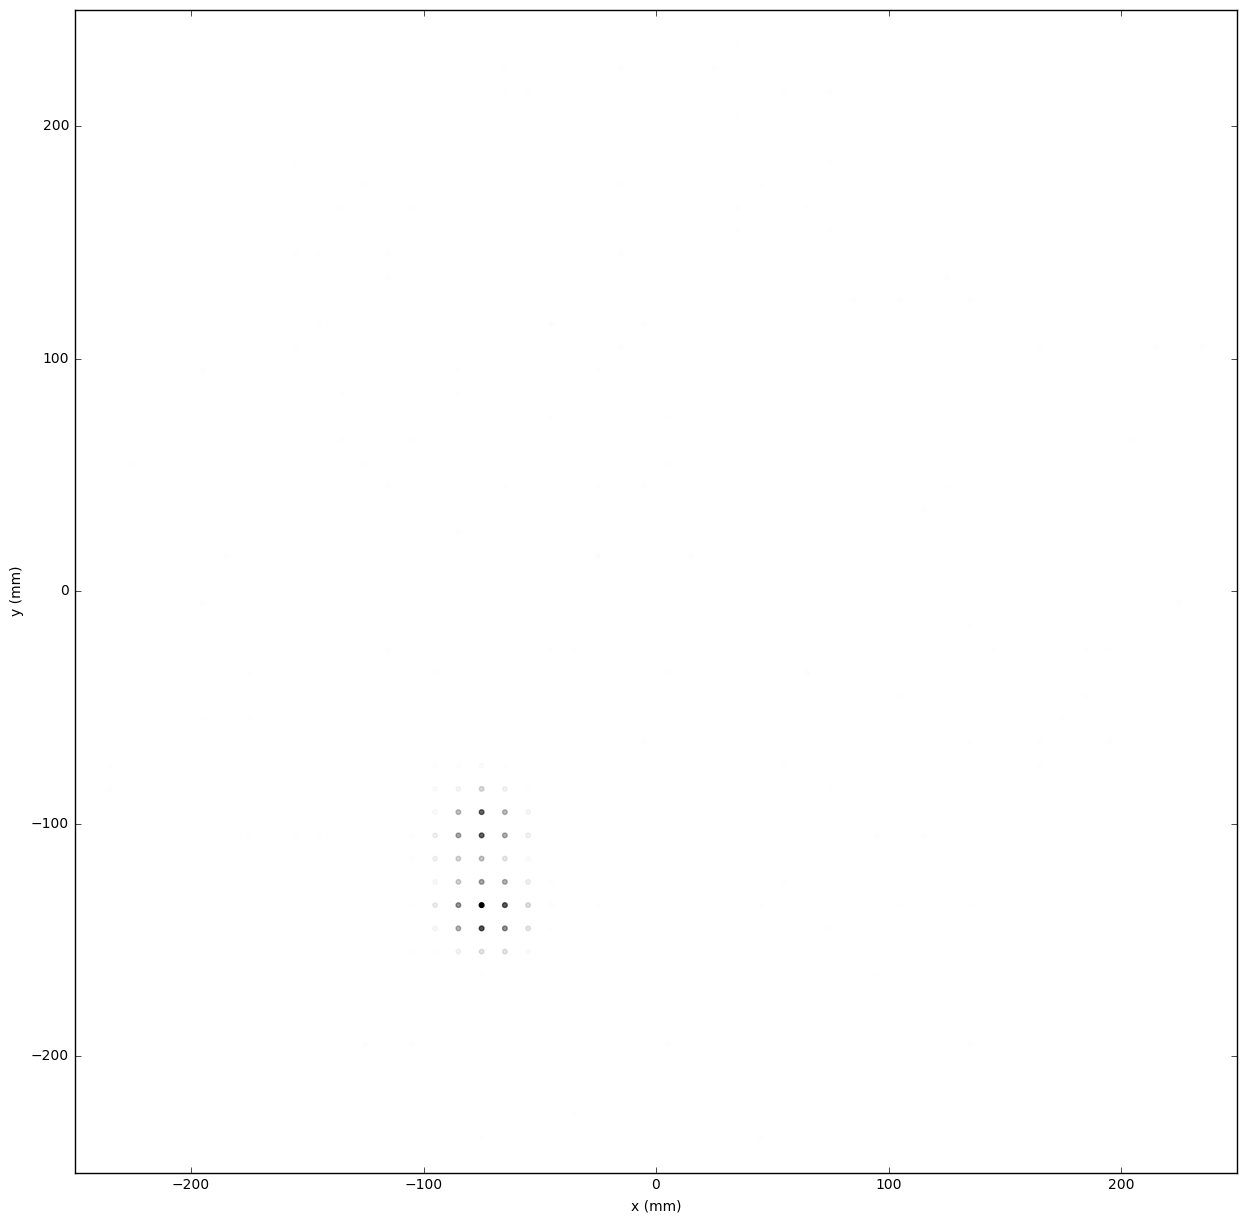

In [11]:
# Plot training event slices.
plt_nevt = 14900
plt_nslice = 5

plt_arr = x_t[plt_nevt,:,:,plt_nslice,0]
NEW_SiPM_map_plot(plt_arr,[0, 0], False)
chg_sum = np.sum(plt_arr)
tot_chg_sum = np.sum(x_t[plt_nevt,0,:,:,:])
max_chg = np.max(x_t[plt_nevt,:,:,plt_nslice,0])
min_chg = np.min(x_t[plt_nevt,:,:,plt_nslice,0])
print("Plotting event", plt_nevt, "slice", plt_nslice, "with charge sum", chg_sum, "and total sum", tot_chg_sum,
     "max charge", max_chg, "and min charge", min_chg)

In [13]:
print(y_t[Ntrain])

[ 0.]
